# Statistical Test for the CLIPScore

In this notebook the CLIPScore will be computed and compared on human and non-human annotated captions. The goal is to understand if the CLIPScore is able to catch the difference in the annotation process that took to the production of the captions. If it is able to do that, than the score is a valid metric to understand how much the captions fit the artworks.

In [1]:
import os
from pathlib import Path
import pandas as pd
import numpy as np
from transformers import CLIPModel, CLIPProcessor
from tqdm import tqdm
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt
import scipy
from PIL import Image

/home/nico/Thesis/neural-artwork-caption-generator/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
PROJECT_DIR = Path(os.getcwd()).resolve().parent
DATA_DIR = PROJECT_DIR / "data"
RAW_DATA_DIR = DATA_DIR / "raw"
PROCESSED_DATA_DIR = DATA_DIR / "processed"
IMAGES_DIR = RAW_DATA_DIR / "images"

In [3]:
df_captions = pd.read_csv(RAW_DATA_DIR / "artgraph_captions.csv")
df_captions

image   
0                         leonardo-da-vinci_mona-lisa.jpg  \
1       henri-de-toulouse-lautrec_in-bed-the-kiss-1892...   
2           sandro-botticelli_the-birth-of-venus-1485.jpg   
3                 claude-monet_madame-monet-and-child.jpg   
4                          gustav-klimt_the-kiss-1908.jpg   
...                                                   ...   
116470                alexander-ivanov_via-appia-1845.jpg   
116471   alexander-ivanov_portrait-of-vittoria-marini.jpg   
116472                   alexander-ivanov_olive-trees.jpg   
116473             alexander-ivanov_annunciation-1824.jpg   
116474  alexander-ivanov_on-the-shore-of-the-bay-of-na...   

                                                     name   
0                            Mona Lisa; Leonardo da Vinci  \
1             In Bed, The Kiss; Henri de Toulouse-Lautrec   
2                   The Birth of Venus; Sandro Botticelli   
3       Camille Monet and a Child in the Artist’s Gard...   
4                                  The Kiss; Gustav Klimt   
...                                                   ...   
116470                        Via Appia; Alexander Ivanov   
116471      Portrait of Vittoria Marini; Alexander Ivanov   
116472                      Olive trees; Alexander Ivanov   
116473                     Annunciation; Alexander Ivanov   
116474  On the shore of the Bay of Naples; Alexander I...   

                                                  caption human  
0       The artwork depicts a woman with a mysterious ...     y  
1       The artwork depicts a couple in bed sharing a ...     y  
2       The artwork depicts a naked woman standing on ...     y  
3       The artwork depicts a woman and child in a gar...     y  
4       The artwork depicts a couple embracing, surrou...     y  
...                                                   ...   ...  
116470  The artwork depicts a scene from the Via Appia...     n  
116471  The artwork depicts a young woman with curly h...     n  
116472  The artwork depicts a group of olive trees on ...     n  
116473  The artwork depicts an angel with outstretched...     n  
116474  The artwork depicts several figures on a beach...     n  

[116475 rows x 4 columns]

In [4]:
# load CLIP
model_url = "openai/clip-vit-base-patch32"
model = CLIPModel.from_pretrained(model_url)
processor = CLIPProcessor.from_pretrained(model_url)

For the test, the captions will be divided into human and not-human annotated captions.

In [5]:
df_human = df_captions[df_captions["human"] == "y"][["image", "caption"]]
df_not_human = df_captions[df_captions["human"] == "n"][["image", "caption"]]

Compare sets of captions of the same size, by excluding the non-human captions.

In [6]:
df_not_human = df_not_human.sample(len(df_human), random_state=42)
df_not_human

image   
99973   louise-elisabeth-vigee-le-brun_self-portrait-w...  \
38014                   thomas-dewing_a-musician-1877.jpg   
32308   ferdinand-hodler_farewell-participating-female...   
88919       william-h-johnson_still-life-flowers-1938.jpg   
60925            charles-turner_william-wallis-1810-1.jpg   
...                                                   ...   
100281  vasily-surikov_krasnoyarsk-kachinskaya-street-...   
63816   benjamin-west_choice-of-hercules-between-virtu...   
41754     thomas-eakins_portrait-of-dr-horatio-c-wood.jpg   
9436    pierre-auguste-renoir_young-girl-slipping-on-h...   
103604  marjorie-acker-phillips_impressionist-landscap...   

                                                  caption  
99973   The artwork depicts Mrs Vigee-Lebrun and her d...  
38014   The artwork depicts a woman playing a stringed...  
32308   The artwork depicts a female figure saying far...  
88919   The artwork depicts a vase with several colorf...  
60925   The artwork depicts a portrait of a man with s...  
...                                                   ...  
100281  The artwork depicts Kachinskaya street in Kras...  
63816   The artwork depicts the choice of Hercules bet...  
41754   The artwork depicts Dr. Horatio C Wood, who is...  
9436    The artwork depicts a young girl seated on a b...  
103604  The artwork depicts a serene and colorful impr...  

[500 rows x 2 columns]

The prefix "The artwork depicts" will be removed from the captions.

In [7]:
def remove_prefix(s):
    words = s.split()
    return " ".join(words[3:])

df_human["caption"] = df_human["caption"].apply(remove_prefix)
df_not_human["caption"] = df_not_human["caption"].apply(remove_prefix)
df_human

image   
0                      leonardo-da-vinci_mona-lisa.jpg  \
1    henri-de-toulouse-lautrec_in-bed-the-kiss-1892...   
2        sandro-botticelli_the-birth-of-venus-1485.jpg   
3              claude-monet_madame-monet-and-child.jpg   
4                       gustav-klimt_the-kiss-1908.jpg   
..                                                 ...   
495           juan-gris_harlequin-with-guitar-1919.jpg   
496                            tintoretto_paradise.jpg   
497     jean-honore-fragonard_the-stolen-kiss-1788.jpg   
498  frederic-leighton_the-fisherman-and-the-syren-...   
499        annibale-carracci_the-flight-into-egypt.jpg   

                                               caption  
0    a woman with a mysterious smile, sitting in fr...  
1           a couple in bed sharing a passionate kiss.  
2    a naked woman standing on a shell on the sea, ...  
3    a woman and child in a garden, surrounded by t...  
4    a couple embracing, surrounded by a golden mos...  
..                                                 ...  
495  a Cubist-style Harlequin figure playing a guit...  
496  a sprawling, heavenly scene filled with angels...  
497  a romantic, clandestine moment between two lov...  
498  a tender encounter between a fisherman and a b...  
499  the Holy Family's flight into Egypt, with Mary...  

[500 rows x 2 columns]

Prepare the captions for the CLIP model.

In [8]:
human_captions = df_human["caption"].tolist()
not_human_captions = df_not_human["caption"].tolist()

Encode the captions to create CLIP embeddings.

In [9]:
human_embeddings = np.empty((1, 512))
not_human_embeddings = np.empty((1, 512))

for i in tqdm(range(0, len(human_captions), 4)):
    batch_hcaptions = human_captions[i : min(i+4, len(human_captions))]
    batch_nhcaptions = not_human_captions[i : min(i+4, len(human_captions))]

    h_inputs = processor(text=batch_hcaptions, images=None, return_tensors="pt", padding=True)
    nh_inputs = processor(text=batch_nhcaptions, images=None, return_tensors="pt", padding=True)

    h_features = model.get_text_features(**h_inputs)
    nh_features = model.get_text_features(**nh_inputs)

    human_embeddings = np.concatenate(
        (human_embeddings, h_features.detach().numpy()), axis=0
    )
    not_human_embeddings = np.concatenate(
        (not_human_embeddings, nh_features.detach().numpy()), axis=0
    )

100%|██████████| 125/125 [00:34<00:00,  3.60it/s]


The precomputed image embeddings are stored in a file, in alphabetical order of the content of the images of the dir.

In [10]:
filenames = sorted(os.listdir(IMAGES_DIR))
filenames

['a-mishra_expression-of-sadness-i.jpg',
 'a-mishra_expression-of-sadness-ii.jpg',
 'a-mishra_expression-of-sadness-iii.jpg',
 'a-mishra_why.jpg',
 'a-y-jackson_a-copse-evening-1918.jpg',
 'a-y-jackson_algoma-in-november-1935.jpg',
 'a-y-jackson_barns-1926.jpg',
 'a-y-jackson_early-spring-quebec-1923.jpg',
 'a-y-jackson_entrance-to-halifax-harbour-1919.jpg',
 'a-y-jackson_first-snow-algoma-country-1920.jpg',
 'a-y-jackson_frozen-lake-early-spring-algonquin-park-1914.jpg',
 'a-y-jackson_grey-day-laurentians-1928.jpg',
 'a-y-jackson_hills-at-great-bear-lake-1953.jpg',
 'a-y-jackson_houses-st-urbain-1934.jpg',
 'a-y-jackson_indian-home-1927.jpg',
 'a-y-jackson_maple-woods-algoma-1920.jpg',
 'a-y-jackson_march-storm-georgian-bay-1920.jpg',
 'a-y-jackson_nellie-lake-1933.jpg',
 'a-y-jackson_night-pine-island-1921.jpg',
 'a-y-jackson_north-shore-lake-superior-1926.jpg',
 'a-y-jackson_october-morning-algoma-wartz-lake-1920.jpg',
 'a-y-jackson_river-st-urbain-1930.jpg',
 'a-y-jackson_st-john-s

In [11]:
image_embeddings = np.load(PROCESSED_DATA_DIR / "clip_embeddings.npy")
image_embeddings = image_embeddings[1:,:] # first embedding is empty

Find alphabetical indices.

In [12]:
h_indices = df_human["image"].apply(lambda x: filenames.index(x)).tolist()
nh_indices = df_not_human["image"].apply(lambda x: filenames.index(x)).tolist()

In [13]:
type(h_indices)

list

In [14]:
h_img_embeddings = image_embeddings[h_indices, :]
nh_img_embeddings = image_embeddings[nh_indices, :]

In [15]:
human_embeddings = human_embeddings[1:,:]
not_human_embeddings = not_human_embeddings[1:,:]

In [16]:
h_scores = np.diagonal(cosine_similarity(h_img_embeddings, human_embeddings))
nh_scores = np.diagonal(cosine_similarity(nh_img_embeddings, not_human_embeddings))

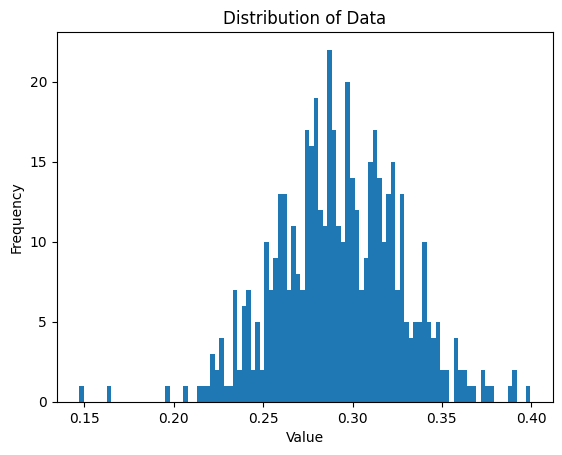

In [17]:
plt.hist(h_scores, bins=100)

# Add labels and a title
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('Distribution of Data')

# Display the plot
plt.show()

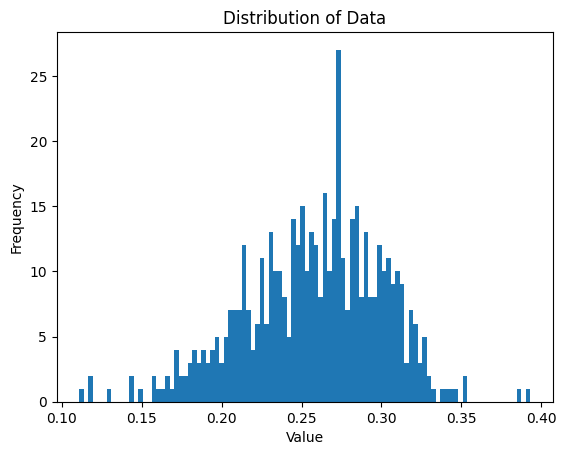

In [18]:
plt.hist(nh_scores, bins=100)

# Add labels and a title
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('Distribution of Data')

# Display the plot
plt.show()

In [19]:
np.var(nh_scores, ddof=1)

0.0018806703115900967

In [20]:
np.var(h_scores, ddof=1)

0.001207265174075783

In [21]:
#define F-test function
def f_test(x, y):
    x = np.array(x)
    y = np.array(y)
    f = np.var(x, ddof=1)/np.var(y, ddof=1) #calculate F test statistic 
    dfn = x.size-1 #define degrees of freedom numerator 
    dfd = y.size-1 #define degrees of freedom denominator 
    p = 1-scipy.stats.f.cdf(f, dfn, dfd) #find p-value of F test statistic 
    return f, p

#perform F-test
f_test(nh_scores, h_scores)

(1.557793889838524, 4.144173407771845e-07)

In [22]:
scipy.stats.ttest_ind(h_scores, nh_scores, equal_var=False)

Ttest_indResult(statistic=14.088741035142805, pvalue=4.363558956442691e-41)

Show the highest and lowest scores.

In [23]:
# get indices of worst and top 3 scores
h_worst = np.argsort(h_scores)[:3]
h_best = np.argsort(h_scores)[-3:]
nh_worst = np.argsort(nh_scores)[:3]
nh_best = np.argsort(nh_scores)[-3:]

In [24]:
df_human

image   
0                      leonardo-da-vinci_mona-lisa.jpg  \
1    henri-de-toulouse-lautrec_in-bed-the-kiss-1892...   
2        sandro-botticelli_the-birth-of-venus-1485.jpg   
3              claude-monet_madame-monet-and-child.jpg   
4                       gustav-klimt_the-kiss-1908.jpg   
..                                                 ...   
495           juan-gris_harlequin-with-guitar-1919.jpg   
496                            tintoretto_paradise.jpg   
497     jean-honore-fragonard_the-stolen-kiss-1788.jpg   
498  frederic-leighton_the-fisherman-and-the-syren-...   
499        annibale-carracci_the-flight-into-egypt.jpg   

                                               caption  
0    a woman with a mysterious smile, sitting in fr...  
1           a couple in bed sharing a passionate kiss.  
2    a naked woman standing on a shell on the sea, ...  
3    a woman and child in a garden, surrounded by t...  
4    a couple embracing, surrounded by a golden mos...  
..                                                 ...  
495  a Cubist-style Harlequin figure playing a guit...  
496  a sprawling, heavenly scene filled with angels...  
497  a romantic, clandestine moment between two lov...  
498  a tender encounter between a fisherman and a b...  
499  the Holy Family's flight into Egypt, with Mary...  

[500 rows x 2 columns]

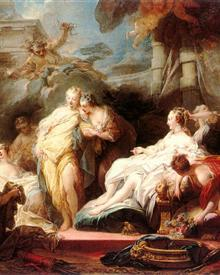

a young woman showing her sisters various objects, including a bow and arrows and a quiver, while standing in a garden.


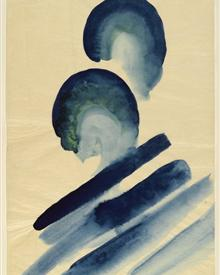

a close-up view of blue petals against a light background, creating a contrast of color and texture.


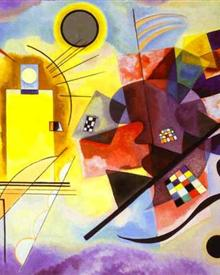

three shapes in yellow, red, and blue floating on a white background.


In [25]:
for i, row in df_human.iloc[h_worst].iterrows():
    display(Image.open(IMAGES_DIR / row["image"]))
    print(row["caption"])

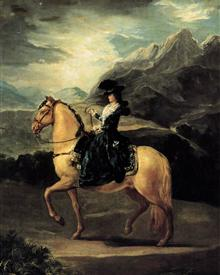

a woman on a brown horse, dressed in a black riding habit and a hat with feathers, riding through a landscape with mountains.


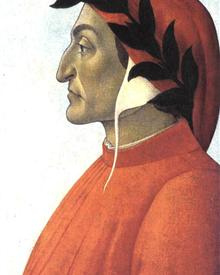

a profile of Dante with a red hat and a laurel crown, against a white background.


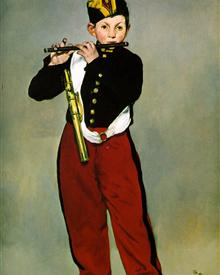

a young boy playing a flute, wearing a black and red uniform.


In [26]:
for i, row in df_human.iloc[h_best].iterrows():
    display(Image.open(IMAGES_DIR / row["image"]))
    print(row["caption"])

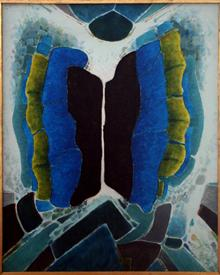

a lush garden hanging from a balcony, featuring vibrant flowers and greenery.
[0.11100511 0.11740063 0.11823536]


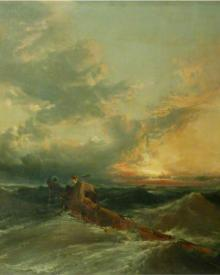

a railway signal tower, with intricate details and patterns.
[0.11100511 0.11740063 0.11823536]


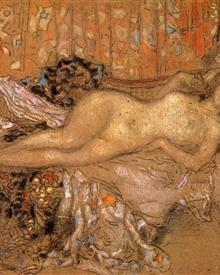

a portrait of an Arabian horse with its shiny brown coat and long mane, standing against a neutral background.
[0.11100511 0.11740063 0.11823536]


In [27]:
for i, row in df_not_human.iloc[nh_worst].iterrows():
    display(Image.open(IMAGES_DIR / row["image"]))
    print(row["caption"])
    print(nh_scores[nh_worst])

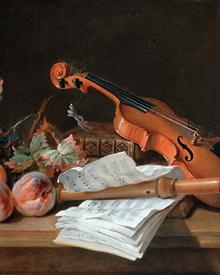

a still life with a violin, a recorder, books, a portfolio of sheet music, peaches, and grapes arranged on a table top, set against a dark background.
[0.3524618  0.38673405 0.39320095]


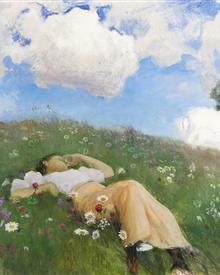

a young girl named Saimi lying on a meadow, surrounded by blooming flowers and grass.
[0.3524618  0.38673405 0.39320095]


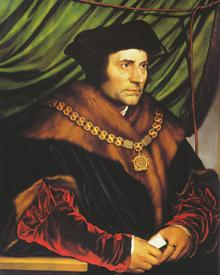

Sir Thomas More wearing a black coat and hat, his hands clasped, with an ermine collar and gold chain of office.
[0.3524618  0.38673405 0.39320095]


In [28]:
for i, row in df_not_human.iloc[nh_best].iterrows():
    display(Image.open(IMAGES_DIR / row["image"]))
    print(row["caption"])
    print(nh_scores[nh_best])

In [29]:
# Get the sorted indices
sorted_indices = np.argsort(nh_scores)

# Sort the array
sorted_arr = nh_scores[sorted_indices]

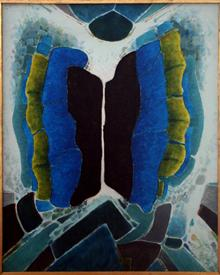

a lush garden hanging from a balcony, featuring vibrant flowers and greenery.
0.11100510508226108


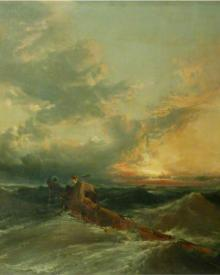

a railway signal tower, with intricate details and patterns.
0.11740062974852544


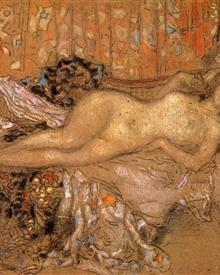

a portrait of an Arabian horse with its shiny brown coat and long mane, standing against a neutral background.
0.11823536352966194


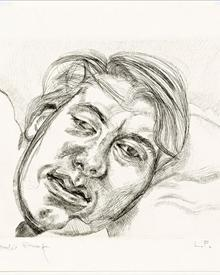

a portrait of a woman, Bella, sitting in front of a dark background, with a fur coat draped over her lap.
0.12942354337339804


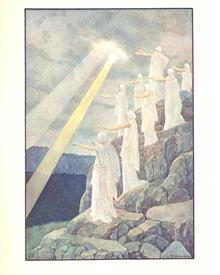

the Vyšehrad Castle during the day, with a river and trees in the foreground. The castle's towers and walls are intricately detailed, and a couple is seen walking on a path leading up to it.
0.14373110495517918


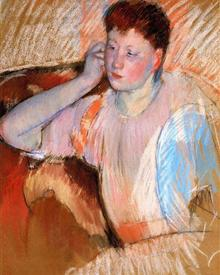

a mother and daughter, standing side by side, dressed in black.
0.14405691053121292


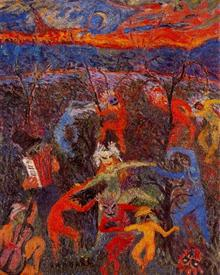

a portrait of a woman with a contemplative expression, against a soft, muted background, emphasizing the texture and color of her clothing and hair.
0.14969900383329166


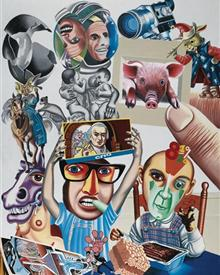

a man with a hat and a suit, standing next to a woman with a red dress, against a background with geometric shapes, colors, and patterns.
0.15770276782859732


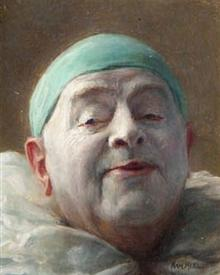

a man with a beard and a mustache, wearing a hat and a black coat, looking to the left.
0.1587617398925655


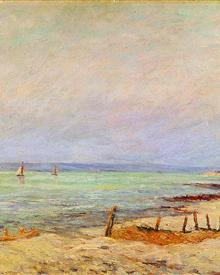

Dusk.
0.1599627185743207


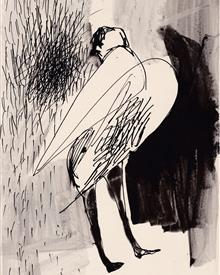

a series of colorful geometric shapes on a dark background.
0.16454171302583803


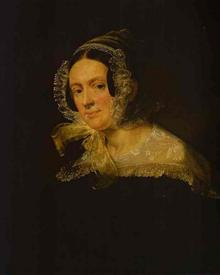

a portrait of E.V. Kireyevsk, a Russian philosopher and writer, known for his contributions to Slavophilism.
0.16521169261953825


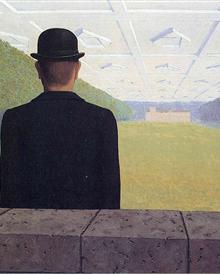

a landscape with a blue sky and clouds, with a large, white building with columns in the foreground. There is a tree and a hill in the background.
0.16652560911643577


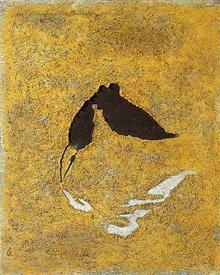

a diver diving into a body of water, with a reflection of the diver visible.
0.16829638419531595


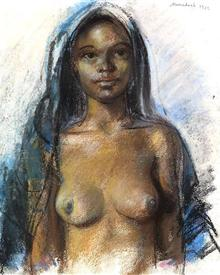

a Moroccan girl wearing a brightly colored dress and jewelry.
0.1714216996444629


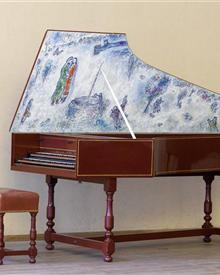

a couple embracing amidst a vibrant, dreamlike landscape.
0.17183930296601074


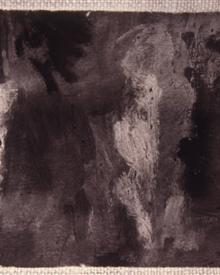

a landscape with trees and a river. The colors are predominantly green and brown, with blue tones in the sky and the water.
0.17242807058583987


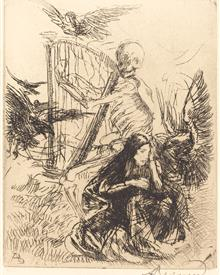

a portrait of a woman musician, holding a violin and bow, with a thoughtful expression and a colorful background.
0.17283044743046894


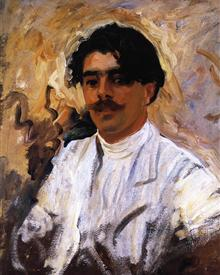

a man with a grey mustache and beard, wearing a suit and tie and standing in front of a dark background.
0.17574962875003194


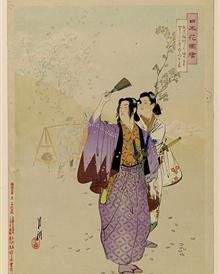

a group of butterflies and flowers in vibrant colors against a dark background.
0.17584929813676886


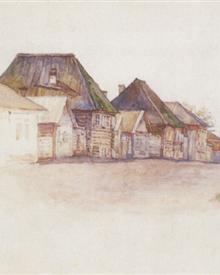

Kachinskaya street in Krasnoyarsk, with colorful buildings and a pedestrian walking down the street.
0.17743598336366667


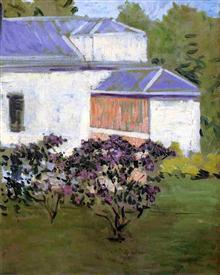

a part of the south façade of the Casin in Yerres, with columns and arches.
0.17847817275346242


In [30]:
for i, score in enumerate(sorted_arr):
    display(Image.open(IMAGES_DIR / df_not_human.iloc[sorted_indices[i]]["image"]))
    print(df_not_human.iloc[sorted_indices[i]]["caption"])
    print(score)
    if i > 20:
        break

In [31]:
filenames_lookup = {v: i for i, v in enumerate(filenames)}

In [32]:
df_captions["filename_index"] = df_captions["image"].apply(lambda x: filenames_lookup[x])

In [38]:
all_captions = df_captions["caption"].tolist()
all_captions = [remove_prefix(c) for c in all_captions]
all_captions

['a woman with a mysterious smile, sitting in front of a landscape.',
 'a couple in bed sharing a passionate kiss.',
 'a naked woman standing on a shell on the sea, surrounded by figures.',
 'a woman and child in a garden, surrounded by trees and flowers.',
 'a couple embracing, surrounded by a golden mosaic pattern.',
 'a sunrise over a harbor with boats and reflections on the water.',
 'a still life with a basket of apples and a bottle on a table with a cloth.',
 'two nude women and two clothed men having a picnic in a forest.',
 'a surreal landscape with strange creatures, plants, and people.',
 'a woman in a golden dress surrounded by patterns and shapes.',
 'a tree in a field with a red background and black lines.',
 "a woman's face in a stylized and elongated form.",
 'abstract shapes and lines in bright colors.',
 'three shapes in yellow, red, and blue floating on a white background.',
 'three dancers practicing in a brightly lit exercise hall.',
 'a girl sitting on a sofa, hold

In [39]:
caption_embeddings = np.empty((1, 512))

for i in tqdm(range(0, len(all_captions), 8)):
    batch_captions = all_captions[i : min(i+8, len(all_captions))]
    # keep only the first 40 words
    batch_captions = [" ".join(c.split()[:40]) for c in batch_captions]

    inputs = processor(text=batch_captions, images=None, return_tensors="pt", padding=True)

    try:
        features = model.get_text_features(**inputs)
    except e:
        print(e)
        print(batch_captions)
        continue

    caption_embeddings = np.concatenate(
        (caption_embeddings, features.detach().numpy()), axis=0
    )

caption_embeddings = caption_embeddings[1:,:]

 22%|██▏       | 3247/14560 [12:41<44:11,  4.27it/s]  


NameError: name 'e' is not defined